## Basic Setup

In [10]:
import numpy as np
import zipfile
from datasets import Dataset
import pandas as pd

import os
# run as much as possible accelerated by apple silicon, fall back to cpu if not possible
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"


import sys
sys.path.append('..')
from scripts.audio import audio_file_to_array
from scripts.ipa import timit2ipa
from scripts.ipa import filter_chars

In [11]:
import sys, os
sys.path.append('..')
from scripts.eval_tests.panphon_model_eval import panphon_model_eval 

In [12]:
# set espeak library path for macOS
if sys.platform == "darwin":
    from phonemizer.backend.espeak.wrapper import EspeakWrapper

    _ESPEAK_LIBRARY = "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
    EspeakWrapper.set_library(_ESPEAK_LIBRARY)

In [13]:
from transformers import AutoProcessor, AutoModelForCTC, AutoTokenizer, AutoFeatureExtractor

In [14]:

PRE_TRAINED_ID = "ginic/gender_split_70_female_4_wav2vec2-large-xlsr-53-buckeye-ipa"

# Load Data

In [15]:
timit = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
timit_files = timit.namelist()

In [16]:
training_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TRAIN'), timit_files))))

In [17]:
WAV_HEADER_SIZE = 44
def zipped_wav_to_array(filename):
    with timit.open(filename) as wav_file:
        return np.frombuffer(wav_file.read(), dtype=np.int16)[WAV_HEADER_SIZE//2:]

## Clean Up Dataset Vocab 
You will see that the initial vocab of most multilingual phoneme transcription models is quite big (300-400 phonemes) we will reduce this in the dataset to improve overall performance for English

In [18]:
# First, ensure that the simplify_timit function is available and works
def simplify_timit(phoneme):
    # Substitute the phoneme based on the dictionary
    substitution_dict = {
        'ɾ̃': 'ɾ',  # Replace nasalized flap with plain flap
        'ŋ̍': 'ŋ',  # Remove syllabic marker from 'ŋ̍'
        'ə̥': 'ə',  # Remove voiceless marker from 'ə̥'
        'ɝ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'ɚ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'l̩': 'l',   # Remove syllabic marker from 'l̩'
        'm̩': 'm',   # Remove syllabic marker from 'm̩'
        'n̩': 'n',   # Remove syllabic marker from 'n̩'
        '̩': '',     # Remove syllabic marker
        'ʉ': 'u',    # Replace high central rounded vowel with high back rounded vowel
        'ɨ': 'i',    # Replace high central unrounded vowel with high front unrounded vowel
        ' ': '',     # Remove nasalization marker
        'ɦ': 'h',    # Replace voiceless glottal fricative with voiceless glottal fricative
        # Add other necessary substitutions if needed
    }
    # Apply the substitution for the phoneme
    return substitution_dict.get(phoneme, phoneme)  # Return simplified phoneme or the original if no replacement

def remove_stress_mark(text):
    """
    Removes the combining double inverted breve (͡) from text.
    
    Args:
        text: String or iterable containing IPA symbols
        
    Returns:
        Text with stress marks removed
    """
    if isinstance(text, str):
        return text.replace('͡', '')
    else:
        raise TypeError("Input must be string, set, or list")
    
# Updated timit_file_to_dict to use the simplified IPA phonemes
def timit_file_to_dict(filename):
    with timit.open(filename + '.PHN') as phn_file:
        timestamped_phonemes = []
        for line in phn_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, phoneme = line.split()
            
            # Convert to IPA first and then simplify the phoneme
            ipa_phonemes = timit2ipa(phoneme, "eng")
            
            # Now filter only the necessary characters (this simplifies the phoneme to the basic form)
            cleaned_ipa = filter_chars(simplify_timit(ipa_phonemes), filter_type="letters")
            cleaned_ipa = remove_stress_mark(cleaned_ipa)
            timestamped_phonemes.append((cleaned_ipa, int(start), int(end)))

    return {'timestamped_phonemes': timestamped_phonemes, 'wav_filename': filename + '.WAV'}

# Updated files_to_df to create DataFrame with cleaned-up phonemes
def files_to_df(files):
    records = []
    for filename in files:
        parsed = timit_file_to_dict(filename)
        parsed['audio'] = zipped_wav_to_array(parsed['wav_filename'])
        del parsed['wav_filename']
        parsed['ipa'] = "".join(phoneme for phoneme, _, _ in parsed['timestamped_phonemes'])
        parsed['phoneme_starts'] = [start for _, start, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_ends'] = [end for _, _, end in parsed['timestamped_phonemes']]
        del parsed['timestamped_phonemes']
        records.append(parsed)
    return pd.DataFrame(records)

# Call files_to_df for your test files
train_df = files_to_df(training_files)
train_df.head()


audio  \
0  [25971, 30303, 29285, 26995, 28271, 11552, 131...   
1  [25971, 30303, 29285, 26995, 28271, 11552, 131...   
2  [25971, 30303, 29285, 26995, 28271, 11552, 131...   
3  [25971, 30303, 29285, 26995, 28271, 11552, 131...   
4  [25971, 30303, 29285, 26995, 28271, 11552, 131...   

                                   ipa  \
0               ʃiddʒɹæsbikɛptnsmɔlzuz   
1  ðiddʒaɪinʔɹɛwʊdsʃɪmɹdinðiɡlɪsniŋsʌn   
2     oʊnʔæskmitikɪɹiinʔɔɪliɹæɡlaɪkðæt   
3           ðəflmuntʃoʊnbɹaɪʔliðætnaɪt   
4  hɹvizbɹθθeɪɪkɹzfɹikwnʔliɔnθɛŋsɡiviŋ   

                                      phoneme_starts  \
0  [0, 2310, 3460, 4280, 4810, 5760, 6767, 8520, ...   
1  [0, 3630, 4300, 5160, 5820, 6800, 9900, 11154,...   
2  [0, 2390, 2660, 4709, 5027, 6558, 9220, 10430,...   
3  [0, 2199, 2730, 3560, 6030, 8371, 9705, 12783,...   
4  [0, 1789, 2340, 3216, 3738, 4315, 5070, 5591, ...   

                                        phoneme_ends  
0  [2310, 3460, 4280, 4810, 5760, 6767, 8520, 972...  
1  [3630, 4300, 5160, 5820, 6800, 9900, 11154, 11...  
2  [2390, 2660, 4709, 5027, 6558, 9220, 10430, 11...  
3  [2199, 2730, 3560, 6030, 8371, 9705, 12783, 13...  
4  [1789, 2340, 3216, 3738, 4315, 5070, 5591, 595...

### Cleaning Up Audio
We will just crop out the start signal :)

In [19]:
def crop_audio(row):
    # Access the phoneme_starts column and get the last value of the list
    end = row['phoneme_starts'][-1]
    # Access the phoneme_ends column and get the first value of the list
    start = row['phoneme_ends'][0]
    # Crop the audio from start to end
    # note that start and end are in samples, not seconds
    cropped_audio = row['audio'][start:end]
    
    return cropped_audio

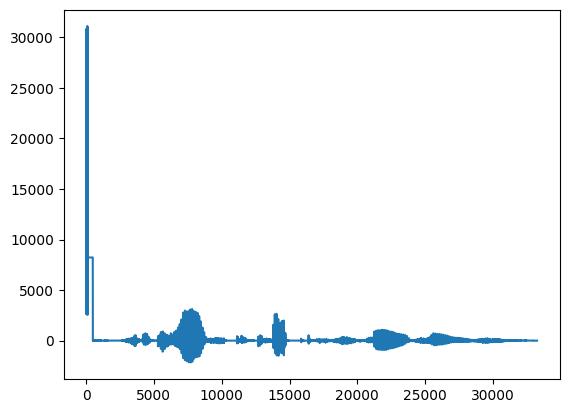

In [20]:
# graph one audio to see start signal that we will remove
import matplotlib.pyplot as plt
plt.plot(train_df['audio'][0])
plt.show()

In [21]:
# Apply the process_row function to each row in the DataFrame
train_df['cropped_audio'] = train_df.apply(crop_audio, axis=1) 
train_df.head()
    

audio  \
0  [25971, 30303, 29285, 26995, 28271, 11552, 131...   
1  [25971, 30303, 29285, 26995, 28271, 11552, 131...   
2  [25971, 30303, 29285, 26995, 28271, 11552, 131...   
3  [25971, 30303, 29285, 26995, 28271, 11552, 131...   
4  [25971, 30303, 29285, 26995, 28271, 11552, 131...   

                                   ipa  \
0               ʃiddʒɹæsbikɛptnsmɔlzuz   
1  ðiddʒaɪinʔɹɛwʊdsʃɪmɹdinðiɡlɪsniŋsʌn   
2     oʊnʔæskmitikɪɹiinʔɔɪliɹæɡlaɪkðæt   
3           ðəflmuntʃoʊnbɹaɪʔliðætnaɪt   
4  hɹvizbɹθθeɪɪkɹzfɹikwnʔliɔnθɛŋsɡiviŋ   

                                      phoneme_starts  \
0  [0, 2310, 3460, 4280, 4810, 5760, 6767, 8520, ...   
1  [0, 3630, 4300, 5160, 5820, 6800, 9900, 11154,...   
2  [0, 2390, 2660, 4709, 5027, 6558, 9220, 10430,...   
3  [0, 2199, 2730, 3560, 6030, 8371, 9705, 12783,...   
4  [0, 1789, 2340, 3216, 3738, 4315, 5070, 5591, ...   

                                        phoneme_ends  \
0  [2310, 3460, 4280, 4810, 5760, 6767, 8520, 972...   
1  [3630, 4300, 5160, 5820, 6800, 9900, 11154, 11...   
2  [2390, 2660, 4709, 5027, 6558, 9220, 10430, 11...   
3  [2199, 2730, 3560, 6030, 8371, 9705, 12783, 13...   
4  [1789, 2340, 3216, 3738, 4315, 5070, 5591, 595...   

                                       cropped_audio  
0  [5, 2, 5, 4, 3, 2, 2, 3, 1, -1, 0, 2, 1, 4, 1,...  
1  [-1, -3, -1, -1, -2, -1, 1, 1, -3, 1, -2, -1, ...  
2  [-2, 2, 1, 2, 4, 3, 4, 5, 8, 4, 5, 3, 4, 3, 4,...  
3  [4, 7, -1, 9, 8, 5, -4, 10, 3, -1, 8, 1, -5, 1...  
4  [1, 1, 0, -5, -5, -3, -3, -4, -3, -4, -3, 0, 5...

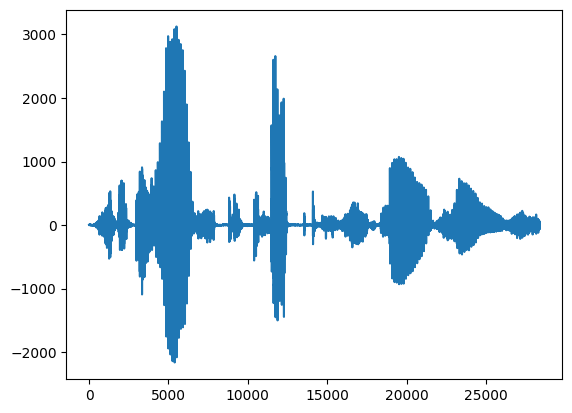

In [22]:
# visualize again, much better!
plt.plot(train_df['cropped_audio'][0])


In [23]:
# train_df comprised of just cropped_audio and phonemes
train_df = train_df.drop(columns=['phoneme_starts', 'phoneme_ends', 'audio'])
# rename cropped audio to audio
train_df = train_df.rename(columns={'cropped_audio': 'audio'})
train_df.head()

ipa  \
0               ʃiddʒɹæsbikɛptnsmɔlzuz   
1  ðiddʒaɪinʔɹɛwʊdsʃɪmɹdinðiɡlɪsniŋsʌn   
2     oʊnʔæskmitikɪɹiinʔɔɪliɹæɡlaɪkðæt   
3           ðəflmuntʃoʊnbɹaɪʔliðætnaɪt   
4  hɹvizbɹθθeɪɪkɹzfɹikwnʔliɔnθɛŋsɡiviŋ   

                                               audio  
0  [5, 2, 5, 4, 3, 2, 2, 3, 1, -1, 0, 2, 1, 4, 1,...  
1  [-1, -3, -1, -1, -2, -1, 1, 1, -3, 1, -2, -1, ...  
2  [-2, 2, 1, 2, 4, 3, 4, 5, 8, 4, 5, 3, 4, 3, 4,...  
3  [4, 7, -1, 9, 8, 5, -4, 10, 3, -1, 8, 1, -5, 1...  
4  [1, 1, 0, -5, -5, -3, -3, -4, -3, -4, -3, 0, 5...

In [24]:
train_ds = Dataset.from_pandas(train_df)

# Extend Phoneme Vocab

In [25]:
timit_vocab = set("".join(train_df['ipa']))
print(timit_vocab)

{'d', 'o', 'ɔ', 'v', 'æ', 'ʊ', 'z', 'l', 'u', 'ŋ', 'i', 's', 'ɾ', 'k', 'ɑ', 'm', 'ɛ', 'ʌ', 'e', 'θ', 'ə', 'h', 'w', 'ʃ', 'ʔ', 'f', 'ð', 'a', 'ɹ', 'j', 'n', 'ʒ', 'p', 'ɡ', 't', 'b', 'ɪ'}


In [26]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_ID)
vocab = tokenizer.get_vocab()
# you will see how large the vocab is, we will resize our linear layer later to make it work for our smaller vocab
print(vocab)

{'A': 267, 'E': 45, 'H': 72, 'I': 20, 'O': 305, 'U': 292, '[PAD]': 310, '[UNK]': 309, '_': 182, 'a': 53, 'ã': 125, 'b': 113, 'b̪': 177, 'b̪͡v': 289, 'b͡ꞵ': 287, 'c': 25, 'cʼ': 229, 'c͡ç': 66, 'd': 176, 'd̼': 118, 'd͡z': 263, 'd͡ð': 244, 'd͡ɮ': 18, 'd͡ʑ': 94, 'd͡ʒ': 280, 'e': 175, 'ẽ': 211, 'e̞': 114, 'ẽ̞': 265, 'f': 139, 'fʼ': 249, 'h': 179, 'i': 245, 'j': 215, 'k': 282, 'kxʼ': 281, 'kǀ': 41, 'kǁ': 61, 'kǂ': 21, 'kǃ': 70, 'kʘ': 79, 'kʼ': 39, 'k̚': 89, 'k͡p': 48, 'k͡x': 198, 'l': 303, 'm': 75, 'm̥': 172, 'n': 102, 'n̥': 28, 'n̼': 169, 'o': 117, 'õ': 119, 'o̞': 62, 'õ̞': 234, 'p': 259, 'pʼ': 286, 'p̚': 149, 'p̪': 273, 'p̪͡f': 105, 'p͡f': 225, 'p͡ɸ': 103, 'q': 130, 'qǀ': 302, 'qǁ': 126, 'qǂ': 299, 'qǃ': 37, 'qʘ': 261, 'qʼ': 58, 'q͡ʡ': 127, 'q͡χʼ': 291, 'q͡ꭓ': 4, 'r': 82, 'r̥': 34, 's': 247, 'sʼ': 200, 't': 307, 'tʼ': 183, 't̚': 241, 't̪͡θʼ': 216, 't̼': 87, 't͡s': 156, 't͡sʼ': 43, 't͡ɕ': 264, 't͡ɬ': 170, 't͡ɬʼ': 164, 't͡ʃ': 91, 't͡ʃʼ': 108, 't͡θ': 140, 'u': 154, 'ũ': 81, 'v': 243, 'w

In [27]:
additional_vocab = timit_vocab.difference(set(vocab.keys()) | {' '})
print("tokens that are in timit but not in the pretrained model", additional_vocab)
tokenizer.add_tokens(list(additional_vocab))

tokens that are in timit but not in the pretrained model set()


0

### Audiomentations 

In [28]:
%pip install audiomentations==0.37.0

Note: you may need to restart the kernel to use updated packages.


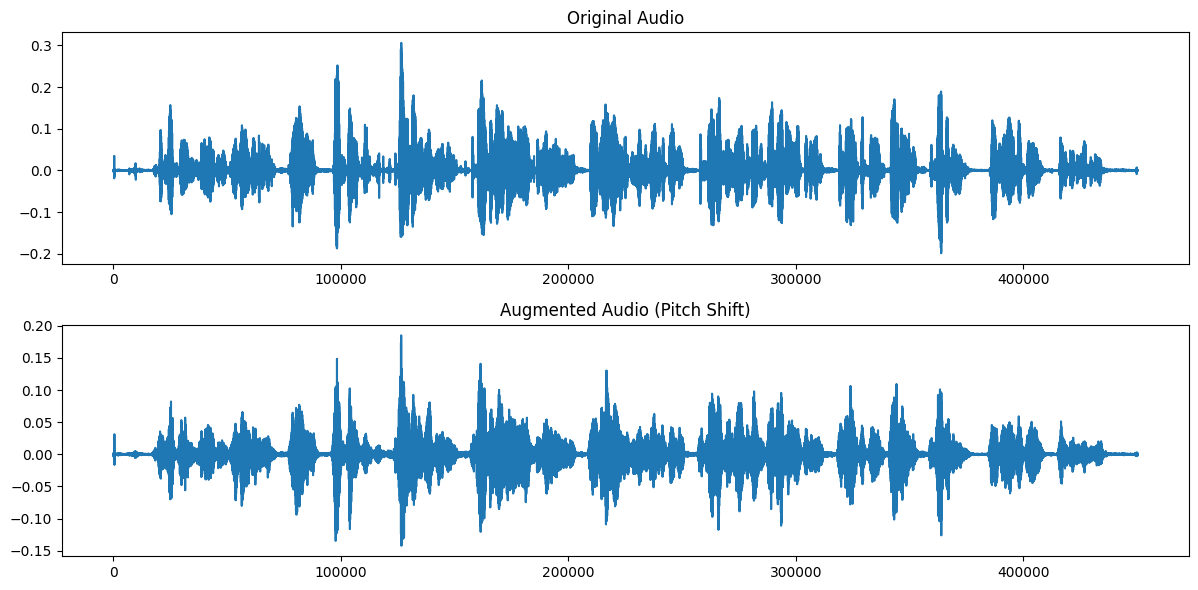


Playing augmented audio:


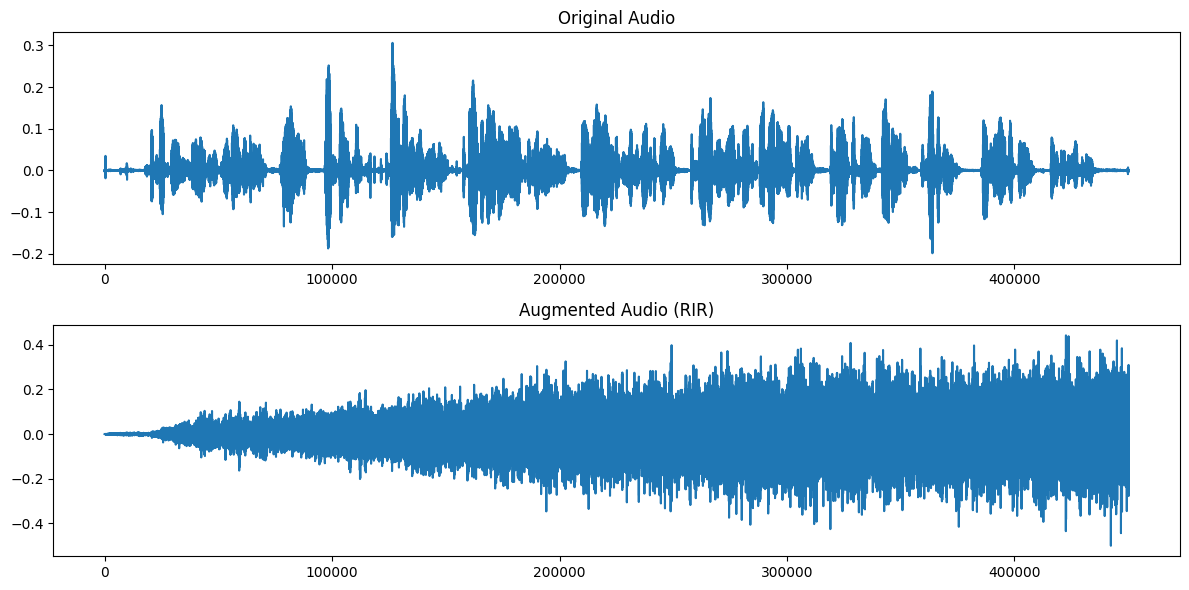


Playing augmented audio:


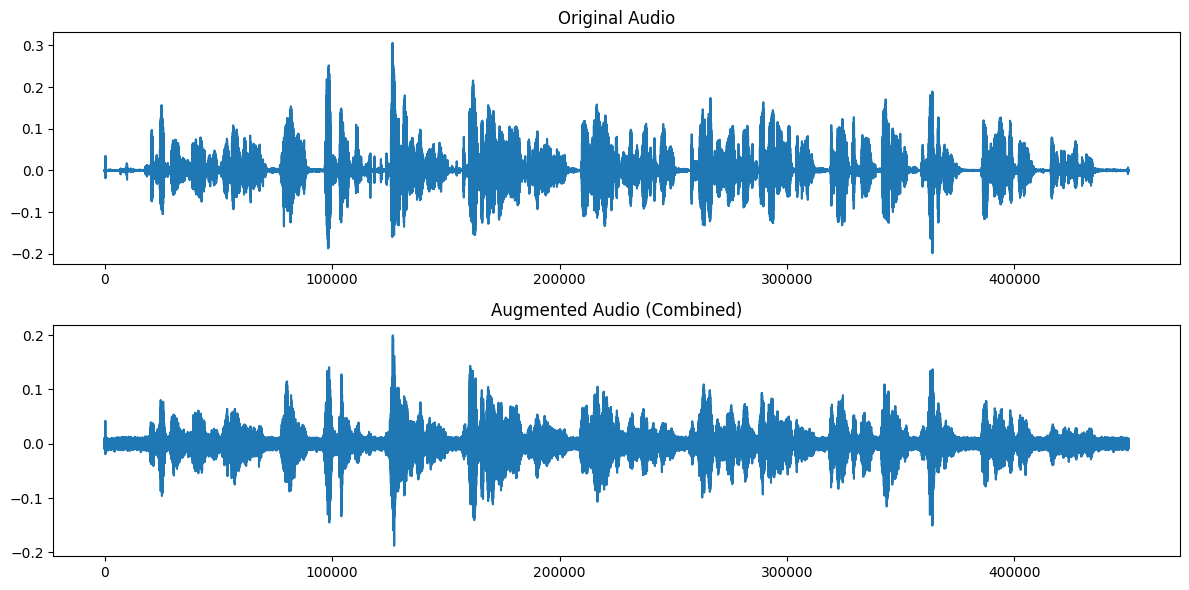


Playing augmented audio:


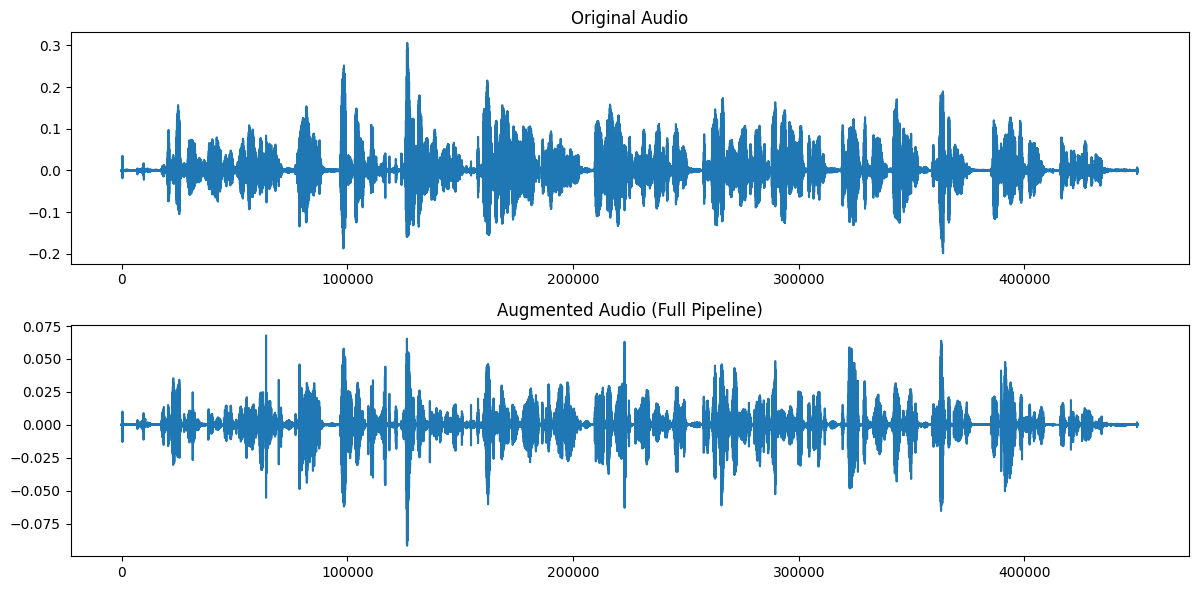


Playing augmented audio:


In [29]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from audiomentations import (
    Compose, AddGaussianNoise, TimeStretch, 
    PitchShift, ApplyImpulseResponse, BandPassFilter
)
import IPython.display as ipd

def plot_and_play_augmentation(samples, augmented_samples, sample_rate, title):
    """Helper function to plot and play audio comparison"""
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.title("Original Audio")
    plt.plot(samples)
    plt.subplot(2, 1, 2)
    plt.title(f"Augmented Audio ({title})")
    plt.plot(augmented_samples)
    plt.tight_layout()
    plt.show()
    
    print("\nPlaying augmented audio:")
    # Play the augmented audio
    ipd.display(ipd.Audio(augmented_samples, rate=sample_rate))

def test_experiments(audio_path):
    """Test all augmentation experiments"""
    # Load audio
    samples, sample_rate = librosa.load(audio_path, sr=16000)
    
    # Experiment 1: Pitch Shift Only
    augment1 = Compose([
        PitchShift(
            min_semitones=-4,
            max_semitones=4,
            p=1.0  # Set to 1.0 for testing
        )
    ])
    augmented1 = augment1(samples=samples, sample_rate=sample_rate)

    plot_and_play_augmentation(samples, augmented1, sample_rate, "Pitch Shift")
    
    # Experiment 2: RIR (Note: Requires impulse response files)
    try:
        augment2 = Compose([
            ApplyImpulseResponse(
                ir_path="/home/arunasri/ML/notebooks/noise_samples/isotropic_noise_selected",
                leave_length_unchanged=True,
                p=1.0
            )
        ])
        augmented2 = augment2(samples=samples, sample_rate=sample_rate)
        plot_and_play_augmentation(samples, augmented2, sample_rate, "RIR")
    except Exception as e:
        print(f"Skipping RIR test (requires impulse response files): {e}")
    
    # Experiment 3: Combined (Pitch Shift + RIR)
    augment3 = Compose([
        PitchShift(
            min_semitones=-4,
            max_semitones=4,
            p=1.0
        ),
        AddGaussianNoise(  # Using noise instead of RIR for testing
            min_amplitude=0.001,
            max_amplitude=0.005,
            p=1.0
        )
    ])
    augmented3 = augment3(samples=samples, sample_rate=sample_rate)
    plot_and_play_augmentation(samples, augmented3, sample_rate, "Combined")
    
    # Experiment 4: Full Pipeline
    augment4 = Compose([
        BandPassFilter( min_center_freq=100.0, max_center_freq=6000, p=1.0)
    ])
    augmented4 = augment4(samples=samples, sample_rate=sample_rate)
    plot_and_play_augmentation(samples, augmented4, sample_rate, "Full Pipeline")

# Usage:
if __name__ == "__main__":
    # Replace with your audio path
    audio_path = "/home/arunasri/ML/data/audio_tests/ArunaBee.wav"
    test_experiments(audio_path)

# Update Feature Extraction

In [30]:
feature_extractor = AutoFeatureExtractor.from_pretrained(PRE_TRAINED_ID)

We don't need to update the feature extractor since it has been pretrained on 16kHz audio which matches the TIMIT dataset.

For datasets with different sampling rates, the feature extractor should be updated or the audio resampled (easier).

This is also where code to add extra features (such as conditioning on speaker's native language etc.) would be added.

# hyperparam search


### Augmentation code

In [31]:
%pip install audiomentations

Note: you may need to restart the kernel to use updated packages.


In [32]:
import numpy as np
import pandas as pd
import torch
from audiomentations import (
    Compose, 
    PitchShift, 
    TimeStretch, 
    BandPassFilter
)

class AudioAugmenter:
    """Handles audio augmentation with different techniques and probabilities"""
    
    def __init__(self):
        # Full augmentation pipeline
        self.full_augment = Compose([
            PitchShift(min_semitones=-4, max_semitones=4, p=1.0),
            TimeStretch(min_rate=0.8, max_rate=1.00, p=1.0),
            BandPassFilter(min_center_freq=100.0, max_center_freq=6000, p=1.0)
        ])
        
        # Individual augmentation techniques
        self.pitch_shift = Compose([
            PitchShift(min_semitones=-4, max_semitones=4, p=1.0)
        ])
        
        self.time_stretch = Compose([
            TimeStretch(min_rate=0.8, max_rate=1.00, p=1.0)
        ])
        
        self.band_pass = Compose([
            BandPassFilter(min_center_freq=100.0, max_center_freq=6000, p=1.0)
        ])
    
    def augment_audio(self, audio, sampling_rate=16000):
        """
        Apply augmentation based on probability distribution:
        - 25% full augmentation
        - 10% pitch shift
        - 10% time stretch
        - 10% band pass filter
        - 45% original
        
        Args:
            audio: audio data (can be list, tensor, or numpy array)
            sampling_rate: audio sampling rate (default: 16000)
            
        Returns:
            augmented audio as numpy array
        """
        # Convert input to numpy array if it isn't already
        if isinstance(audio, (list, tuple)):
            audio = np.array(audio, dtype=np.float32)
        elif isinstance(audio, torch.Tensor):
            audio = audio.numpy().astype(np.float32)
        elif isinstance(audio, np.ndarray):
            audio = audio.astype(np.float32)
        else:
            raise ValueError(f"Unsupported audio type: {type(audio)}")
        
        # Ensure audio is 1D
        if len(audio.shape) > 1:
            audio = audio.squeeze()
        rand_val = np.random.random()
        
        if rand_val < 0.25:  # 25% full augmentation
            return self.full_augment(samples=audio, sample_rate=sampling_rate)
        elif rand_val < 0.35:  # 10% pitch shift
            return self.pitch_shift(samples=audio, sample_rate=sampling_rate)
        elif rand_val < 0.45:  # 10% time stretch
            return self.time_stretch(samples=audio, sample_rate=sampling_rate)
        elif rand_val < 0.55:  # 10% band pass
            return self.band_pass(samples=audio, sample_rate=sampling_rate)
        else:  # 45% original
            return audio

def augment_dataset(df, augmenter=None):
    """
    Augment audio data in the dataframe.
    Ensures all audio data is properly converted to float32 numpy arrays.
    """
    if augmenter is None:
        augmenter = AudioAugmenter()
    
    augmented_df = df.copy()
    augmented_df['audio'] = augmented_df['audio'].apply(
        lambda x: augmenter.augment_audio(x)
    )
    
    return augmented_df

## V2 resize finetuning 

In [34]:
import torch
import logging
import wandb
import json
import time
from datetime import datetime
import os
from transformers import AutoProcessor, AutoModelForCTC, Trainer, TrainingArguments, EarlyStoppingCallback, TrainerCallback
from datasets import Dataset
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
from sklearn.model_selection import train_test_split
import numpy as np
import torchaudio
import GPUtil

# Constants
SAMPLING_RATE = 16000
MAX_AUDIO_LENGTH = 160000  # 10 seconds at 16kHz
MAX_LABEL_LENGTH = 100
OUTPUT_DIR = "./results/INTERSPEECH_no_resize_noiseA_train"

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class TimingCallback(TrainerCallback):
    """Custom callback to track training time and metrics"""
    def __init__(self, output_file):
        self.output_file = output_file
        self.start_time = None
        self.training_stats = {
            'start_time': None,
            'gpu_type': self._get_gpu_type(),
            'timestamps': []
        }

    def on_train_begin(self, args, state, control, **kwargs):
        self.start_time = time.time()
        self.training_stats['start_time'] = datetime.now().isoformat()

    def on_log(self, args, state, control, logs={}, **kwargs):
        current_time = time.time()
        gpu_metrics = self._get_gpu_metrics()
        
        timestamp = {
            'step': state.global_step,
            'elapsed_seconds': current_time - self.start_time,
            'train_loss': logs.get('loss'),
            'eval_loss': logs.get('eval_loss'),
            **gpu_metrics
        }
        self.training_stats['timestamps'].append(timestamp)
        
        # Save to JSONL file
        with open(self.output_file, 'a') as f:
            json.dump(timestamp, f)
            f.write('\n')

    def on_train_end(self, args, state, control, **kwargs):
        self.training_stats['total_time'] = time.time() - self.start_time
        
        # Save final summary
        summary_file = os.path.join(os.path.dirname(self.output_file), 'training_summary.json')
        with open(summary_file, 'w') as f:
            json.dump(self.training_stats, f, indent=2)

    def _get_gpu_type(self):
        try:
            gpu = GPUtil.getGPUs()[0]
            return gpu.name
        except:
            return "Unknown"
            
    def _get_gpu_metrics(self):
        try:
            gpu = GPUtil.getGPUs()[0]
            return {
                'gpu_utilization': gpu.load * 100,
                'gpu_memory_used': gpu.memoryUsed,
                'gpu_memory_total': gpu.memoryTotal
            }
        except:
            return {
                'gpu_utilization': None,
                'gpu_memory_used': None,
                'gpu_memory_total': None
            }

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    """
    processor: AutoProcessor
    padding: Union[bool, str] = "longest"

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        max_length = min(
            max(len(feature["input_values"]) for feature in features),
            MAX_AUDIO_LENGTH
        )
        
        padded_inputs = []
        attention_mask = []
        for feature in features:
            input_length = len(feature["input_values"])
            padding_length = max_length - input_length
            
            input_values = (torch.tensor(feature["input_values"]) 
                          if isinstance(feature["input_values"], list) 
                          else feature["input_values"])
            
            input_values = input_values.squeeze()
            
            if padding_length > 0:
                padded_input = torch.nn.functional.pad(input_values, (0, padding_length))
                attention_mask.append(torch.cat([torch.ones(input_length), 
                                              torch.zeros(padding_length)]))
            else:
                padded_input = input_values
                attention_mask.append(torch.ones(input_length))
            
            padded_inputs.append(padded_input)

        batch = {
            "input_values": torch.stack(padded_inputs),
            "attention_mask": torch.stack(attention_mask)
        }

        with self.processor.as_target_processor():
            label_features = [{"input_ids": feature["labels"]} for feature in features]
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch

def preprocess_audio(audio_input):
    """Load and preprocess audio to match expected format."""
    if isinstance(audio_input, str):
        waveform, sample_rate = torchaudio.load(audio_input)
        audio_numpy = waveform.squeeze().numpy()
    elif isinstance(audio_input, (list, np.ndarray, torch.Tensor)):
        audio_numpy = np.array(audio_input, dtype=np.float32)
    else:
        raise ValueError(f"Unsupported audio type: {type(audio_input)}")
    
    audio_numpy = audio_numpy.astype(np.float32)
    if len(audio_numpy.shape) > 1:
        audio_numpy = np.mean(audio_numpy, axis=0)
    
    if np.abs(audio_numpy).max() > 1:
        audio_numpy = audio_numpy / np.abs(audio_numpy).max()
    
    if len(audio_numpy) > MAX_AUDIO_LENGTH:
        audio_numpy = audio_numpy[:MAX_AUDIO_LENGTH]
    elif len(audio_numpy) < MAX_AUDIO_LENGTH:
        padding = np.zeros(MAX_AUDIO_LENGTH - len(audio_numpy), dtype=np.float32)
        audio_numpy = np.concatenate([audio_numpy, padding])
    
    return audio_numpy



def prepare_datasets(train_df, processor):
    """Prepare datasets for training and evaluation."""
    logger.info("Splitting dataset into train and evaluation...")
    train_data, eval_data = train_test_split(train_df, test_size=0.2, random_state=42)
    
    def process_data(batch):
        audio = preprocess_audio(batch["audio"]).squeeze()
        inputs = processor(
            audio, 
            sampling_rate=SAMPLING_RATE, 
            return_tensors=None
        )
        
        input_values = np.squeeze(inputs["input_values"])
        
        with processor.as_target_processor():
            labels = processor(batch["ipa"]).input_ids
        
        return {
            "input_values": input_values,
            "labels": labels,
            "audio": audio
        }
    
    train_dataset = Dataset.from_pandas(train_data)
    eval_dataset = Dataset.from_pandas(eval_data)
    
    train_dataset = train_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in train_dataset.column_names if col != "audio"]
    )
    eval_dataset = eval_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in eval_dataset.column_names if col != "audio"]
    )
    
    return train_dataset, eval_dataset


def train_model(train_df, pre_trained_id):
    """Main training function with best hyperparameters."""
    # Create output directory if it doesn't exist
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    timing_file = os.path.join(OUTPUT_DIR, 'training_timing.jsonl')
    
    # Initialize wandb
    wandb.init(
        project="INTERSPEECH_no_resize_noiseA_train",
        name="full_training_run_v2",
        config={
            "learning_rate": 9.999999999999999e-05,
            "batch_size": 4,
            "gradient_accumulation_steps": 4,
            "num_epochs": 20
        }
    )
    
    # Initialize model and processor
    logger.info("Initializing model and processor...")
    processor = AutoProcessor.from_pretrained(pre_trained_id)
    model = AutoModelForCTC.from_pretrained(pre_trained_id)
    model.gradient_checkpointing_enable()
    
    # Save processor and vocab immediately
    processor_dir = os.path.join(OUTPUT_DIR, "processor")
    processor.save_pretrained(processor_dir)
    
    # Save vocabulary separately for easier access
    vocab_file = os.path.join(OUTPUT_DIR, "vocab.json")
    with open(vocab_file, 'w') as f:
        json.dump(processor.tokenizer.get_vocab(), f, indent=2)
    
    # Prepare datasets
    logger.info("Preparing datasets...")
    train_dataset, eval_dataset = prepare_datasets(train_df, processor)
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        learning_rate=3.1622776601683795e-05,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=4,
        num_train_epochs=20,
        warmup_ratio=0.1,
        weight_decay=0.01,
        max_grad_norm=1.0,
        adam_beta1=0.9,
        adam_beta2=0.975,
        adam_epsilon=1e-08,
        logging_steps=50,
        save_steps=100,
        eval_steps=100,
        evaluation_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        save_strategy="steps",
        save_total_limit=2,
        fp16=True,
        dataloader_num_workers=16,
        gradient_checkpointing=True,
        dataloader_prefetch_factor=4,
        ddp_find_unused_parameters=False,
        resume_from_checkpoint=True
    )
    
    # Create trainer with custom callbacks
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=DataCollatorCTCWithPadding(processor=processor, padding="longest"),
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=5),  # Increased patience
            TimingCallback(timing_file)
        ]
    )
    
    # Train and evaluate
    logger.info("Starting training...")
    train_result = trainer.train()
    
    # Final evaluation
    eval_result = trainer.evaluate()
    
    # Log final results
    wandb.log({
        "final_eval_loss": eval_result["eval_loss"],
        "final_train_loss": train_result.training_loss
    })
    
    # Save final model
    trainer.save_model(os.path.join(OUTPUT_DIR, "final_model"))
    
    wandb.finish()
    
    return trainer, eval_result, processor_dir

if __name__ == "__main__":
    augmenter = AudioAugmenter()
    augmented_df = augment_dataset(train_df, augmenter)
    
    trainer, eval_result, processor_dir = train_model(augmented_df, PRE_TRAINED_ID)
    logger.info(f"Training complete. Final eval loss: {eval_result['eval_loss']}")
    logger.info(f"Processor and vocab saved to: {processor_dir}")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aruna-sri (aruna-team). Use `wandb login --relogin` to force relogin


2025-02-03 07:07:06,936 - INFO - Initializing model and processor...
2025-02-03 07:07:08,228 - INFO - Preparing datasets...
2025-02-03 07:07:08,230 - INFO - Splitting dataset into train and evaluation...
Map (num_proc=4):   0%|          | 0/3696 [00:00<?, ? examples/s]/home/arunasri/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Map (num_proc=4):   3%|▎         | 112/3696 [00:07<01:29, 39.93 examples/s]/home/arunasri/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

/home/arunasri/ML/venv/lib/python3.8/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/home/arunasri/ML/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/arunasri/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in

2025-02-03 08:37:42,551 - INFO - Training complete. Final eval loss: 0.7445011734962463
2025-02-03 08:37:42,551 - INFO - Processor and vocab saved to: ./results/INTERSPEECH_no_resize_noiseA_train/processor


## Save Model on Hugging Face

In [ ]:
from transformers import AutoModelForCTC, Wav2Vec2Processor
from huggingface_hub import login

# Log in to Hugging Face (if not already logged in)
# login("your-huggingface-api-token")

# Load the model and processor from your local directory
model = AutoModelForCTC.from_pretrained("/home/arunasrivastava/ML/notebooks/results-b0")
processor = Wav2Vec2Processor.from_pretrained("/home/arunasrivastava/ML/notebooks/results-b0")

# Specify the directory where you want to save the model
save_directory = "./xlsr-timit-b0"

# Save and upload to Hugging Face Model Hub under an organization
model.save_pretrained(save_directory, push_to_hub=True, repo_id="KoelLabs/xlsr-timit-b0")
processor.save_pretrained(save_directory)


# Instructions to Upload Model to Hugging Face

1. **Login to Hugging Face**  
   Run the following command to log in to your Hugging Face account:
   ```bash
   huggingface-cli login


2. **Create a Repository**  
   Run the following command to log in to your Hugging Face account:
   ```bash
   huggingface-cli repo create your-model-name --organization your-org-name

3. **Git clone**  
   Run the following command to clone your repo:
   ```bash 
   git clone https://huggingface.co/your-org-name/your-model-name

4. **Upload Model**  (if you did not make it on Hugging Face already)
   Run the following command to clone your repo:
   ```bash 
   huggingface-cli repo upload --path ./<path here>


5. **Move Other Files**  
   Run the following command to copy each file into the repo:
   ```bash
   cp -r ./<path here> <your-cloned-repo-folder> 

6. **Stage & Commit!**
    Run the following git commands
    ```bash
    git add README.md
    git commit -m "Add model card"
    git push


### YAAAAY CONGRATULATIONS 

In [ ]:
%pip install optuna joblib
# you can use WADNB sweeps as well, whatever is easier

## Hyperparam no_resize


In [ ]:

import json
import torch
import logging
import optuna
import tempfile
from transformers import AutoProcessor, AutoModelForCTC, Trainer, TrainingArguments, TrainerCallback, EarlyStoppingCallback
from datasets import Dataset
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torchaudio
from sklearn.model_selection import train_test_split
from itertools import product
from datetime import datetime
import time
import GPUtil
import psutil
import wandb

# Constants
SAMPLING_RATE = 16000
MAX_AUDIO_LENGTH = 160000  # 10 seconds at 16kHz
MAX_LABEL_LENGTH = 100

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    """
    processor: AutoProcessor
    padding: Union[bool, str] = "longest"

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Add max length check
        max_length = min(
            max(len(feature["input_values"]) for feature in features),
            MAX_AUDIO_LENGTH
        )
        # Pad input_values
        padded_inputs = []
        attention_mask = []
        for feature in features:
            input_length = len(feature["input_values"])
            padding_length = max_length - input_length
            
            # Convert to tensor and ensure correct shape
            if isinstance(feature["input_values"], list):
                input_values = torch.tensor(feature["input_values"])
            else:
                input_values = feature["input_values"]
            
            # Remove any extra dimensions and ensure it's 1D
            input_values = input_values.squeeze()
            
            # Pad with zeros
            if padding_length > 0:
                padded_input = torch.nn.functional.pad(input_values, (0, padding_length))
                attention_mask.append(torch.cat([torch.ones(input_length), torch.zeros(padding_length)]))
            else:
                padded_input = input_values
                attention_mask.append(torch.ones(input_length))
            
            padded_inputs.append(padded_input)

        # Stack all padded inputs ensuring correct dimensions [batch_size, sequence_length]
        batch = {
            "input_values": torch.stack(padded_inputs),
            "attention_mask": torch.stack(attention_mask)
        }

        # Process labels
        with self.processor.as_target_processor():
            label_features = [{"input_ids": feature["labels"]} for feature in features]
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # Replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch

def preprocess_audio(audio_input):
    """
    Load and preprocess audio to match expected format.
    """
    # Handle different input types
    if isinstance(audio_input, str):  # File path
        waveform, sample_rate = torchaudio.load(audio_input)
        audio_numpy = waveform.squeeze().numpy()
        
    elif isinstance(audio_input, list):  # List input
        audio_numpy = np.array(audio_input, dtype=np.float32)
        
    elif isinstance(audio_input, np.ndarray):  # Already numpy array
        audio_numpy = audio_input
        
    elif isinstance(audio_input, torch.Tensor):  # Torch tensor
        audio_numpy = audio_input.numpy()
        
    else:
        raise ValueError(f"Unsupported audio type: {type(audio_input)}")
    
    # Ensure float32 dtype
    audio_numpy = audio_numpy.astype(np.float32)
    
    # Ensure 1D array
    if len(audio_numpy.shape) > 1:
        audio_numpy = np.mean(audio_numpy, axis=0)
    
    # Normalize audio
    if np.abs(audio_numpy).max() > 1:
        audio_numpy = audio_numpy / np.abs(audio_numpy).max()
    
    # Trim or pad to max length
    if len(audio_numpy) > MAX_AUDIO_LENGTH:
        audio_numpy = audio_numpy[:MAX_AUDIO_LENGTH]
    elif len(audio_numpy) < MAX_AUDIO_LENGTH:
        padding = np.zeros(MAX_AUDIO_LENGTH - len(audio_numpy), dtype=np.float32)
        audio_numpy = np.concatenate([audio_numpy, padding])
    
    return audio_numpy

def prepare_datasets(train_df, processor):
    """
    Dataset preparation compatible with original data collator
    """
    logger.info("Splitting dataset into train and evaluation...")
    
    train_data, eval_data = train_test_split(train_df, test_size=0.2, random_state=42)
    
    def process_data(batch):
        # Preprocess audio
        audio = preprocess_audio(batch["audio"])
        audio = audio.squeeze()
        
        # Process audio without any padding or tensor conversion
        inputs = processor(
            audio, 
            sampling_rate=SAMPLING_RATE, 
            return_tensors=None
        )
        
        input_values = np.squeeze(inputs["input_values"])
        
        # Process labels without any padding or tensor conversion
        with processor.as_target_processor():
            labels = processor(batch["ipa"]).input_ids
        
        return {
            "input_values": input_values,
            "labels": labels,
            "audio": audio
        }
    
    # Convert DataFrames to Datasets with optimized batch processing
    train_dataset = Dataset.from_pandas(train_data)
    eval_dataset = Dataset.from_pandas(eval_data)
    
    # Apply processing with larger batches
    train_dataset = train_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in train_dataset.column_names if col != "audio"]
    )
    eval_dataset = eval_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in eval_dataset.column_names if col != "audio"]
    )
    
    return train_dataset, eval_dataset

class TrialTimeTracker:
    """Track detailed timing information for each trial"""
    def __init__(self, output_file):
        self.output_file = output_file
        self.current_trial = None
        self.start_time = None
        
    def start_trial(self, trial_config, trial_id):
        """Start timing a new trial with specific configuration"""
        self.current_trial = {
            'trial_id': trial_id,
            'config': trial_config,
            'start_time': datetime.now().isoformat(),
            'gpu_type': self._get_gpu_type(),
            'timestamps': []
        }
        self.start_time = time.time()
        
    def log_timestamp(self, step_name):
        """Log a timestamp during the trial"""
        if self.current_trial:
            gpu_metrics = self._get_gpu_metrics()
            timestamp = {
                'step': step_name,
                'elapsed_seconds': time.time() - self.start_time,
                **gpu_metrics
            }
            self.current_trial['timestamps'].append(timestamp)
            logger.info(f"Step {step_name} completed after {timestamp['elapsed_seconds']:.2f}s")
            
    def end_trial(self, eval_loss=None):
        """End the current trial and save results"""
        if self.current_trial:
            self.current_trial['total_time'] = time.time() - self.start_time
            if eval_loss is not None:
                self.current_trial['eval_loss'] = eval_loss
            
            with open(self.output_file, 'a') as f:
                json.dump(self.current_trial, f)
                f.write('\n')
            
            logger.info(f"Trial {self.current_trial['trial_id']} completed in {self.current_trial['total_time']:.2f}s")
            if eval_loss is not None:
                logger.info(f"Eval loss: {eval_loss:.4f}")
            
            trial_summary = self.current_trial.copy()
            self.current_trial = None
            return trial_summary
    
    def _get_gpu_type(self):
        try:
            gpu = GPUtil.getGPUs()[0]
            return gpu.name
        except:
            return "Unknown"
            
    def _get_gpu_metrics(self):
        try:
            gpu = GPUtil.getGPUs()[0]
            return {
                'gpu_utilization': gpu.load * 100,
                'gpu_memory_used': gpu.memoryUsed,
                'gpu_memory_total': gpu.memoryTotal
            }
        except:
            return {
                'gpu_utilization': None,
                'gpu_memory_used': None,
                'gpu_memory_total': None
            }

def test_worker_count(num_workers):
    """Test if a specific worker count works"""
    try:
        test_loader = torch.utils.data.DataLoader(
            range(100), 
            batch_size=16,
            num_workers=num_workers,
            prefetch_factor=2
        )
        return True
    except Exception as e:
        logger.warning(f"Worker count {num_workers} failed: {str(e)}")
        return False

def generate_systematic_configs():
    """Generate systematic hyperparameter configurations using ranges from original code"""
    # Define the grid points for each parameter
    configs = []
    
    # Use log-spaced points for learning rate
    learning_rates = np.logspace(-6, -4, num=5)  # 5 points between 1e-6 and 1e-4
    batch_sizes = [4, 8, 16]
    grad_accums = [2, 4, 8]
    warmup_ratios = [0.05, 0.1, 0.15]  # 3 points
    weight_decays = np.logspace(-3, -1, num=3)  # 3 points between 0.001 and 0.1
    max_grad_norms = [0.5, 1.0, 2.0]
    adam_beta1s = [0.85, 0.9, 0.95]
    adam_beta2s = [0.95, 0.975, 0.999]
    adam_epsilons = np.logspace(-9, -7, num=3)  # 3 points
    
    # Take a systematic subset to keep total trials manageable
    # Prioritize learning rate, batch size, and gradient accumulation variations
    primary_configs = list(product(
        learning_rates,
        batch_sizes,
        grad_accums
    ))
    
    # Use middle values for other parameters to keep trial count reasonable
    secondary_params = {
        'warmup_ratio': warmup_ratios[1],
        'weight_decay': weight_decays[1],
        'max_grad_norm': max_grad_norms[1],
        'adam_beta1': adam_beta1s[1],
        'adam_beta2': adam_beta2s[1],
        'adam_epsilon': adam_epsilons[1]
    }
    
    # Generate final configurations
    for lr, bs, ga in primary_configs:
        config = {
            'learning_rate': float(lr),
            'per_device_train_batch_size': bs,
            'per_device_eval_batch_size': bs,
            'gradient_accumulation_steps': ga,
            **secondary_params
        }
        configs.append(config)
    
    return configs

def get_completed_trials(results_file):
    """Read the results file to determine which trials have been completed"""
    completed_trials = set()
    try:
        with open(results_file, 'r') as f:
            for line in f:
                try:
                    trial_data = json.loads(line)
                    # Only count trials that completed successfully (have eval_loss)
                    if 'trial_id' in trial_data and 'eval_loss' in trial_data:
                        completed_trials.add(trial_data['trial_id'])
                except json.JSONDecodeError:
                    continue
    except FileNotFoundError:
        logger.info("No previous results file found. Starting from beginning.")
    return completed_trials

def run_systematic_search(train_df, pre_trained_id, data_collator, resume_file="INTERSPEECH_no_resize_noiseA.jsonl"):
    """Run systematic hyperparameter search with resume capability"""
    configs = generate_systematic_configs()
    logger.info(f"Generated {len(configs)} configurations for systematic search")
    
    # Get completed trials
    completed_trials = get_completed_trials(resume_file)
    logger.info(f"Found {len(completed_trials)} completed trials")
    
    tracker = TrialTimeTracker(output_file=resume_file)
    
    # Test for highest stable worker count before starting trials
    worker_counts = [32, 24, 16]  # Try these counts in descending order
    num_workers = 16  # Default fallback
    for count in worker_counts:
        if test_worker_count(count):
            num_workers = count
            logger.info(f"Selected {num_workers} workers for all trials")
            break
    
    for trial_idx, config in enumerate(configs):
        # Skip completed trials
        if trial_idx in completed_trials:
            logger.info(f"Skipping completed trial {trial_idx}")
            continue
            
        logger.info(f"\nStarting trial {trial_idx + 1}/{len(configs)}")
        logger.info(f"Configuration: {json.dumps(config, indent=2)}")
        
        # Initialize wandb with unique name
        run_name = f"trial_{trial_idx}_noresize_v2_resumed"
        wandb.init(
            project="INTERSPEECH_no_resize_noiseA",
            name=run_name,
            config=config,
            reinit=True
        )
        
        try:
            # Start tracking this trial
            tracker.start_trial(config, trial_idx)
            
            # Initialize model and processor
            tracker.log_timestamp("model_init_start")
            processor = AutoProcessor.from_pretrained(pre_trained_id)
            model = AutoModelForCTC.from_pretrained(pre_trained_id)
            model.gradient_checkpointing_enable()
            tracker.log_timestamp("model_init_complete")
            
            # Prepare datasets
            tracker.log_timestamp("dataset_prep_start")
            train_dataset, eval_dataset = prepare_datasets(train_df, processor)
            tracker.log_timestamp("dataset_prep_complete")
            
            # Training arguments with checkpointing
            output_dir = f"./results/INTERSPEECH_no_resize_noiseA/trial_{trial_idx}"
            training_args = TrainingArguments(
                output_dir=output_dir,
                **config,
                num_train_epochs=5,
                logging_steps=50,
                save_steps=100,
                eval_steps=100,
                evaluation_strategy="steps",
                load_best_model_at_end=True,
                metric_for_best_model="eval_loss",
                greater_is_better=False,
                save_strategy="steps",
                save_total_limit=2,
                fp16=True,
                dataloader_num_workers=num_workers,
                gradient_checkpointing=True,
                dataloader_prefetch_factor=4,
                ddp_find_unused_parameters=False,
                resume_from_checkpoint=True
            )
            
            # Create trainer
            tracker.log_timestamp("training_start")
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=eval_dataset,
                data_collator=data_collator(processor=processor, padding="longest"),
                callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
            )
            
            # Train and evaluate
            train_result = trainer.train()
            tracker.log_timestamp("training_complete")
            
            eval_result = trainer.evaluate()
            tracker.log_timestamp("evaluation_complete")
            
            # Log to wandb
            wandb.log({
                "eval_loss": eval_result["eval_loss"],
                "train_loss": train_result.training_loss,
                "num_workers": num_workers
            })
            
            # End trial and save results
            tracker.end_trial(eval_loss=eval_result["eval_loss"])
            
        except Exception as e:
            logger.error(f"Error in trial {trial_idx}: {str(e)}")
            tracker.end_trial()
        
        finally:
            wandb.finish()
    
    return resume_file


if __name__ == "__main__":  
    # Create augmenter and augment dataset
    augmenter = AudioAugmenter()
    augmented_df = augment_dataset(train_df, augmenter)
    
    # Run systematic search with augmented dataset
    results_file = run_systematic_search(
        train_df=augmented_df,
        pre_trained_id=PRE_TRAINED_ID,  # Replace with your pretrained model ID
        data_collator=DataCollatorCTCWithPadding,
        resume_file="INTERSPEECH_no_resize_noiseA.jsonl"
    )